# GPS Tracker

This program reads a gpx file containing a series of waypoints (time, latitude, longitude, elevation) in xml format. Since I wrote the program to evaluate gpx files of runs (recorded with the Runkeeper app), each gpx track will be refered to as a <i>run</i> and some of the nomenclature was chosen with that in mind. The program then extracts some metrics of the run:
<ul>
    <li>Total distance</li>
    <li>Total time</li>
    <li>Average pace</li>
    <li>Total climb</li>
</ul>
Additionally, the program will make a series of plots to visualize the run:
<ul>
    <li>Elevation profile</li>
    <li>Pace over time</li>
    <li>Map with elevation colorcode</li>
</ul>
First, we import some modules:

In [3]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import geopy.distance

## Loading gpx file
The function load_run_to_df(filename) uses the the <b>gpxpy</b> module to read the specified gpx file into a Pandas DataFrame with four columns (time, latitude, longitude, elevation). It then adds a fifth column with the accumulated distance (which is calculated using the <b>geopy</b> module. The DataFrame with five columns is returned.

In [4]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'lat': [],'lon': [],'elev': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
    tmp = [0]
    for i, row in df[1:].iterrows():
        prevCoord = (df.iloc[i-1]['lat'],df.iloc[i-1]['lon'])
        currCoord = (df.iloc[i]['lat'],df.iloc[i]['lon'])
        tmp.append(tmp[-1] + geopy.distance.vincenty(prevCoord, currCoord).mi)
    df['accuDist']=tmp
    
    return df

In [5]:
df = load_run_to_df('RK_gpx _2018-05-19_0757.gpx')
df.head()

,elev,lat,lon,time,accuDist
0,23.0,37.447922,-122.183063,2018-05-19 14:57:00,0.000000
1,23.0,37.447878,-122.183106,2018-05-19 14:57:04,0.003847
2,23.0,37.447780,-122.183102,2018-05-19 14:57:13,0.010609
3,23.0,37.447717,-122.182983,2018-05-19 14:57:17,0.018463
4,23.0,37.447663,-122.182879,2018-05-19 14:57:21,0.025287


## Extract run metrics
Having already calculated the accumulated distance for each point when we loaded the file, it is straighforward to read the total distance off the last entry of the DataFrame.

In [6]:
# Calculate total distance of this run
total_distance = df.iloc[-1]['accuDist']    
print('Total distance: \t%.2f mi' % total_distance)

Total distance: 	15.56 mi


The total time is taken from the difference of the first and last timestamps. The resulting timedelta object is converted to a formatted string using the function strfdelta.

In [8]:
# Calculate total time of this run
from time import strftime

def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

Total time: 	2:22:50


The average pace is calculated from the above timedelta object and the total distance and formatted as min:sec per mile.

In [9]:
# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per mi' % (avg_pace_min, avg_pace_sec))

Average pace: 	9:10 per mi


The total climb is the accumulated elevation difference of all intervals between two consecutive waypoints with a positive incline. That mean we are adding up the uphill elevation differences, but do not subtract downhill parts.

In [7]:
# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = 3.28084*(df.iloc[i]['elev'] - df.iloc[i-1]['elev'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

Total climb: 	321.2


## Visualize the run
First we plot an elevtion profile as a function of distance using matplotlib. This is where our additional DataFrame column containing the accumulated distance comes in handy.

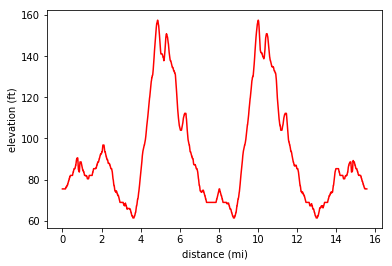

In [8]:
# Plot height profile and calculate total climb
import matplotlib.pyplot as plt

plt.plot(df['accuDist'],3.28084*df['elev'], 'r')
plt.ylabel('elevation (ft)')
plt.xlabel('distance (mi)')
plt.show()

Next we want to make a plot showing the current pace as a function of distance. The is a little more involved than the elevation profile because the current pace is not readiy available in the DataFrame. First we calculate the pace for each interval between two waypoints (that's pace_hist). 

Since the waypoints are only a few seconds apart, the data a very noisy (you can tell from the grey trace in the below plot). We reduce the noise by removing spikes and taking a running average using numpy's convolve method. These data are shown as a red trace in the plot (the remaining spikes are real: I did actually slow down). The blue line indicates the average pace of the whole run.

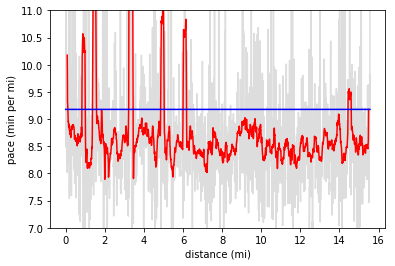

In [11]:
# Calculate current pace
import numpy as np
import copy

# pace_hist is a list of paces between two points each
pace_hist=[]
for i, row in df[1:].iterrows():
    time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
    pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
    curr_pace = time_diff.seconds / pos_diff
    pace_hist.append(curr_pace/60)
    
# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])
        
        
# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
# Plot original pace trace in grey and spike-removed, averaged trace in red
plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r')
plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b')
plt.ylabel('pace (min per mi)')
plt.xlabel('distance (mi)')
plt.ylim(7,11)
#plt.xlim(2,4)
plt.show()


It's interesting to note that the average pace is substantially influenced by the 'slow' spikes!

Finally, we plot a map of the run in which the local elevation is represented by a color map. This allows us to locate uphill and downhill portions of the run.

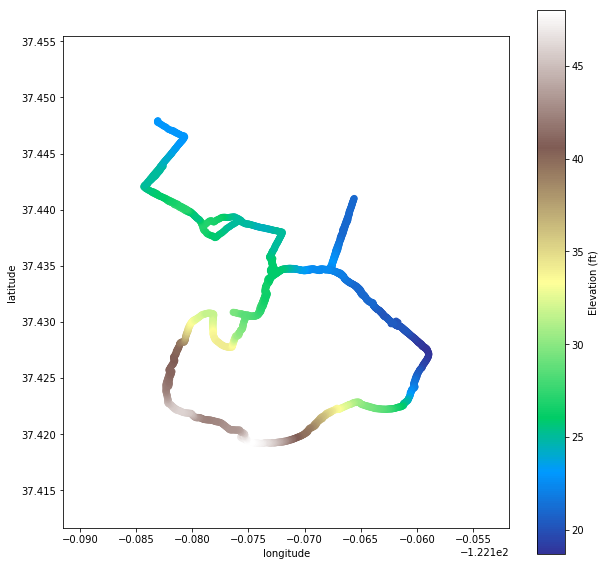

In [80]:
from matplotlib.cm import terrain # import color map

# Plot running path
plt.scatter(df['lon'],df['lat'],c=df['elev'], cmap=terrain)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar().set_label('Elevation (ft)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()